In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
#from torchvision.datasets import MNIST

#mnist = MNIST(root='data', 
              #train=True, 
              #download=True,
              #transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
data=r"D:\GANS\DATA\archive\images\images\Alfred_Sisley"

In [104]:
import os
print(os.listdir(data))



['Alfred_Sisley', 'Alfred_Sisley_1.jpg', 'Alfred_Sisley_10.jpg', 'Alfred_Sisley_100.jpg', 'Alfred_Sisley_101.jpg', 'Alfred_Sisley_102.jpg', 'Alfred_Sisley_103.jpg', 'Alfred_Sisley_104.jpg', 'Alfred_Sisley_105.jpg', 'Alfred_Sisley_106.jpg', 'Alfred_Sisley_107.jpg', 'Alfred_Sisley_108.jpg', 'Alfred_Sisley_109.jpg', 'Alfred_Sisley_11.jpg', 'Alfred_Sisley_110.jpg', 'Alfred_Sisley_111.jpg', 'Alfred_Sisley_112.jpg', 'Alfred_Sisley_113.jpg', 'Alfred_Sisley_114.jpg', 'Alfred_Sisley_115.jpg', 'Alfred_Sisley_116.jpg', 'Alfred_Sisley_117.jpg', 'Alfred_Sisley_118.jpg', 'Alfred_Sisley_119.jpg', 'Alfred_Sisley_12.jpg', 'Alfred_Sisley_120.jpg', 'Alfred_Sisley_121.jpg', 'Alfred_Sisley_122.jpg', 'Alfred_Sisley_123.jpg', 'Alfred_Sisley_124.jpg', 'Alfred_Sisley_125.jpg', 'Alfred_Sisley_126.jpg', 'Alfred_Sisley_127.jpg', 'Alfred_Sisley_128.jpg', 'Alfred_Sisley_129.jpg', 'Alfred_Sisley_13.jpg', 'Alfred_Sisley_130.jpg', 'Alfred_Sisley_131.jpg', 'Alfred_Sisley_132.jpg', 'Alfred_Sisley_133.jpg', 'Alfred_Sisle

In [105]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [106]:
image_size = 256
batch_size = 1
stats = (100, 100,100), (100,100, 100)
train_ds = ImageFolder(data, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [107]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
stats[1][0]

100

In [109]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [110]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

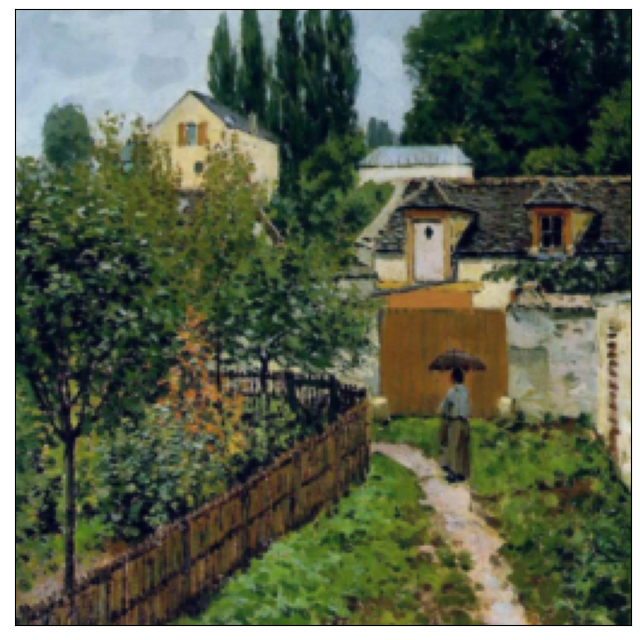

In [111]:
show_batch(train_dl)

first batch
torch.Size([1, 3, 256, 256])
tensor([0])


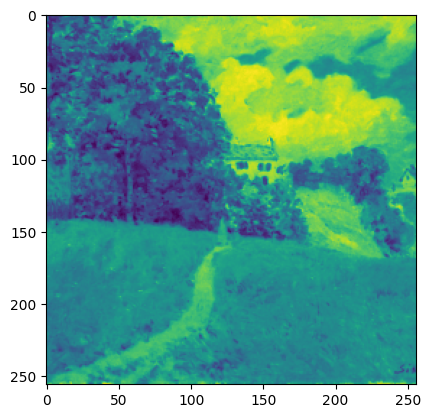

In [74]:
for img_batch, label_batch in train_dl:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0])
    print(label_batch)
    break

In [80]:
256*256

65536

In [75]:
# Device configurationa
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [79]:
device
train_dl = DeviceDataLoader(train_dl, device)

In [187]:
image_size = 65536
hidden_size = 256

In [188]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [189]:
D.to(device)

Sequential(
  (0): Linear(in_features=65536, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## 65536*256

In [169]:
latent_size = 65536

In [170]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [171]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 256,256)).detach())

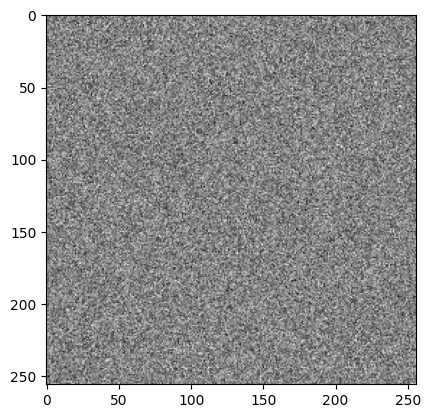

In [172]:
plt.imshow(gen_imgs[0], cmap='gray');

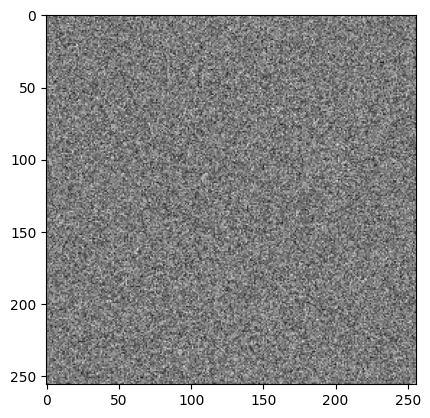

In [173]:
plt.imshow(gen_imgs[1], cmap='gray');

In [174]:
G.to(device)

Sequential(
  (0): Linear(in_features=65536, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=65536, bias=True)
  (5): Tanh()
)

In [175]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [176]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [177]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [178]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images




In [179]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

torch.Size([1, 3, 256, 256])


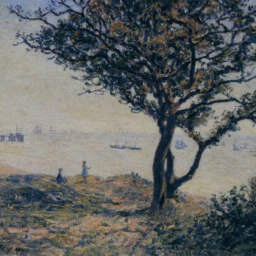

In [180]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in train_dl:
   # images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    print(images.shape)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


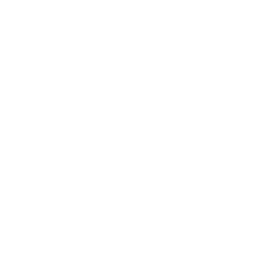

In [181]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 256, 256)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [182]:
%%time

num_epochs = 300
total_step = len(train_dl)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_dl):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x196608 and 65536x128)

In [183]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [ ]:
Image('./samples/fake_images-0010.png')

In [ ]:
Image('./samples/fake_images-0050.png')

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');